In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import isambard
from isambard.modelling import pack_side_chains_scwrl

# Motivation
In this notebook, we will build a parametric model for a dimer made of single-chain anti-parallel tetramer. Then, we choose a sequence and optimise the parameters of dimer.

# scapTet as the monomer
The building block of the dimer is a single-chain anti-parallel tetramer stored in `scapTet.pdb` file. First we read this pdb file and get its `Assembly` object. Then, we define a function for this assembly that returns a local coordinate system of our building block. The local coordinate system is useful when we want to build a parametric model from this building block (e.g. a dimer).

An instance of `protein_design.specifications.Monomer` is constructed from the monomer assembly and its local-coordinate-system function. We will use `Monomer` to build a dimer (or higher order assemblies). 

Moreover, the `Monomer.visualise()` method with the option `coordinate_system=True` can be used to visualise the monomer, and its local coordinate system (you'll need to install `nglview` for this).

In [2]:
# load pdb file to an assembly
scapTet_pdb_path = 'scapTet.pdb'
scapTet = isambard.ampal.load_pdb(scapTet_pdb_path)

# make sure that cenre of mass of the scapTet is at origin
scapTet.translate(-scapTet.centre_of_mass)

define the local coordinate system for scapTet

In [3]:
def get_coordinate_system_scapTet(monomer):
    '''Caclulates the local coordinate system of a monomer of scapTet 
    Local coordinate system contains 3 orthogonal unit vectors representing the orientation of the monomer.
    
    Args:
        monomer (isambard.ampal.Assembly): Assembly object containing the scapTet 
    
    Returns:
        A tuple of 3 (np.ndarray) vectors (v24, v13, z) where  
            v24 extends from helix 2 to helix 4
            v13 extends from helix 1 to helix 3
            z = v24 cross v13
    '''
    start = np.sum([monomer[0][1:13].backbone.centre_of_mass,
                    monomer[0][44:56].backbone.centre_of_mass,
                    monomer[0][64:76].backbone.centre_of_mass,
                    monomer[0][108:122].backbone.centre_of_mass], axis=0)/4.
    end = np.sum([monomer[0][13:26].backbone.centre_of_mass,
                  monomer[0][32:44].backbone.centre_of_mass,
                  monomer[0][76:89].backbone.centre_of_mass,
                  monomer[0][95:108].backbone.centre_of_mass], axis=0)/4.
    z=end-start
    z/=np.linalg.norm(z)
    
    v13 = monomer[0][1:26].backbone.centre_of_mass - monomer[0][64:89].backbone.centre_of_mass
    v24 = monomer[0][32:56].backbone.centre_of_mass - monomer[0][95:122].backbone.centre_of_mass
    v13 -= np.dot(v13,z)*z
    v24 -= np.dot(v24,z)*z
    v13 /= np.linalg.norm(v13)
    v24 /= np.linalg.norm(v24)
    
    return v24, v13, z 

In [4]:
from protein_design.specifications import Monomer
monomer = Monomer(scapTet, get_coordinate_system_func=get_coordinate_system_scapTet)
view = monomer.visualise(coordinate_system=True)
view

NGLWidget()

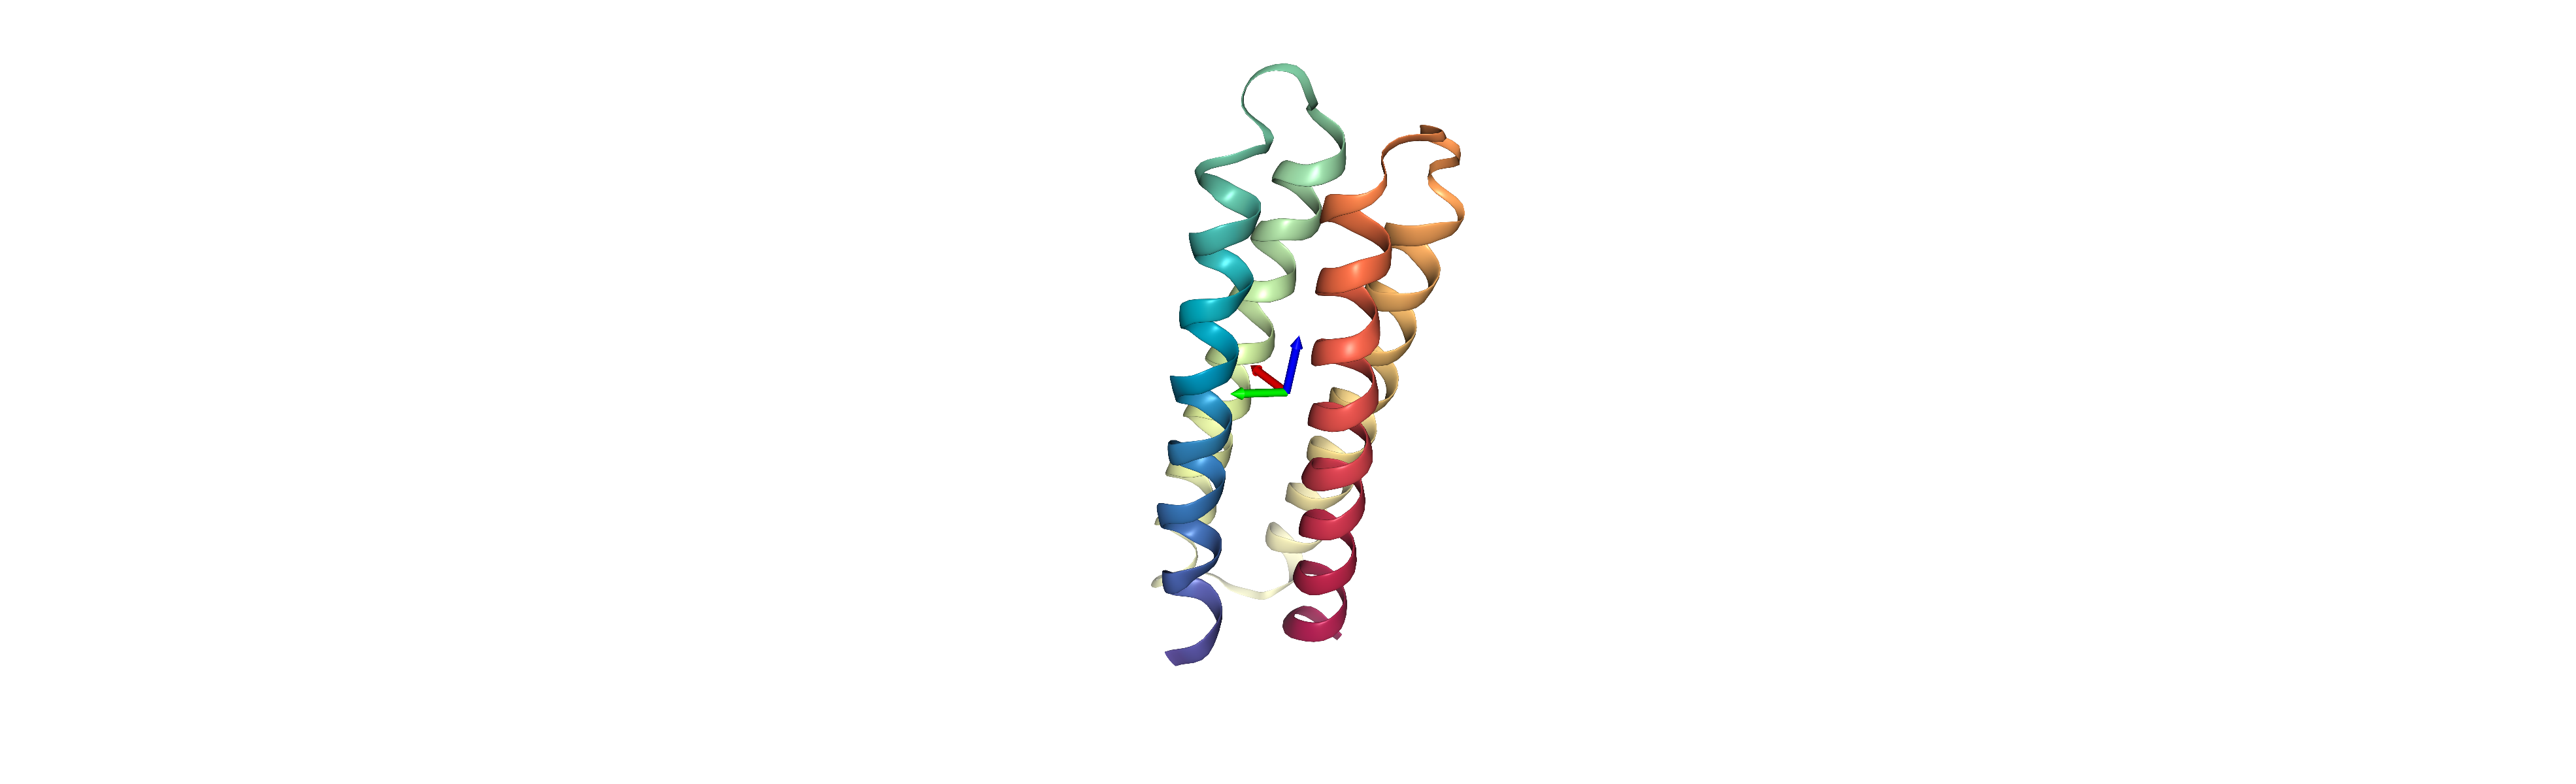

In [7]:
view.render_image()
view._display_image()

# Parametric model for the dimer
`Dimer` class builds a parametric model for the dimer from the monomer.  The relative position and orientation of the second monomer is specified relative to the first monomer using spherical coordinate system with parameters (`r`, `theta`, `phi`) and Euler angles (`alpha`, `beta`, `gamma`), respectively.

Our conventions for the ranges of the parameters:
- `r` : [0, inf]
- `phi`, `alpha` & `gamma` : [0, 360]
- `theta` & `beta` : [0, 180]

Notes:
- In `Dimer` class, we added a property that checks for overlaps between the two backbone atoms. This is useful when optimising the parameters. Because we do not want to call the expensive side-chain packing function for dimers with overlap. 

In [8]:
from protein_design.specifications import Dimer

# building an anti-paraller dimer
dimer = Dimer(monomer, r=21, theta=90, phi=0, alpha=0, beta=180, gamma=0)
dimer.visualise(coordinate_system=True)

NGLWidget()

In [9]:
dimer.num_overlaps()

0

In [10]:
dimer._molecules

[<Polypeptide containing 123 Residues. Sequence: GELEALAQELEA...>,
 <Polypeptide containing 123 Residues. Sequence: GELEALAQELEA...>]

# Choose a sequence and pack side-chains
Here, we choose the dimer sequence and pack the side chains around the rigid back-bone using [Scwrl4](http://dunbrack.fccc.edu/SCWRL3.php/). Since the sequence is not the same for the two monomers this model is *hetero-dimer*.

*Notes*
- I noticed that on macOS the latest `Scwrl4` requires passing an additional argument `-p configuration_file`. This may cause `isambard.modelling.pack_side_chains_scwrl()` to fail. My hack to avoid this problem was:
    
```
scwrl_root=/Users/majid/scwrl4  # replace this path with the path to your own Scwrl4
cd ${scwrl_root}
mv Scwrl4 Scwrl4_
echo '#!/bin/bash' > Scwrl4
echo '${scwrl_root}/Scwrl4_ -p ${scwrl_root}/Scwrl4.ini "$@"' >> Scwrl4
chmod +x Scwrl4
```
 
- You'll also need to add the `Scwrl4` path (i.e. `scwrl_root` above) to your PATH (see [here](https://stackoverflow.com/a/14638025))

- After successful packing of the side-chains, `dimer.tags` should contain the packing score in `key='scwrl_score'`.

In [8]:
sequences = ["""
                G  ELEALAQ ELEALAQ KLKALAQ KLKAL   TSDS 
                Q  ELEELAE ALEDLAE WLKELAQ KLKA    RARLD
                AQ ELEELAE ELEELAE WLKDLAQ KLKAL   TSDS
                Q  ELEALAQ ELEALAE KLKALAQ KLKALAQ
             """,
             """
                G  ELERLAA ELERLAK KLKALAQ KLKAL   TSDS
                Q  ELEALAQ ELEALAE KLKALAQ KLKA    RARLD
                AQ ELEALAQ ELEALAQ KLKALAQ KLKAL   TSDS
                Q  ELERLAR ELEKLAK KLKALAQ KLKALAQ
             """]
sequences = [s.replace(" ", "").replace("\n", "") for s in sequences]
sequences

['GELEALAQELEALAQKLKALAQKLKALTSDSQELEELAEALEDLAEWLKELAQKLKARARLDAQELEELAEELEELAEWLKDLAQKLKALTSDSQELEALAQELEALAEKLKALAQKLKALAQ',
 'GELERLAAELERLAKKLKALAQKLKALTSDSQELEALAQELEALAEKLKALAQKLKARARLDAQELEALAQELEALAQKLKALAQKLKALTSDSQELERLARELEKLAKKLKALAQKLKALAQ']

In [9]:
# note that the output of the function `pack_side_chains_scwrl()` is not of type `Dimer`.
dimer = pack_side_chains_scwrl(dimer, sequences=dimer.sequences, rigid_rotamer_model=False)
dimer.tags

{'scwrl_score': 718.305}

# Optimise hetero-dimer parameters
Now we are ready to optimise the parameters of our parametric model by minimising the BUDE energy for the sequence chosen above.

In [9]:
# we will use custom (more efficient) energy calculation and build functions
from protein_design.specifications import get_buff_total_energy
from protein_design.specifications import build_model

import isambard.optimisation.evo_optimizers as ev_opts
from isambard.optimisation.evo_optimizers import Parameter

## Define the search space
For each dynamic parameters, we specify their mean and the maximum variance around the mean.
For static parameters, we give their values.

In [11]:
parameters = [
    Parameter.static('monomer', monomer),
    Parameter.dynamic('a', 22, 3),
    Parameter.dynamic('theta', 90, 90),
    Parameter.dynamic('phi', 180, 180),
    Parameter.dynamic('alpha', 180, 180),
    Parameter.dynamic('beta', 90, 90),
    Parameter.dynamic('gamma', 180, 180),
]

## Run optimisation
For demonstration, we run a very short search using genetic algorithm (`GA`). Note that with such a short search we cannot be sure if the minimum energy configuration found is a global one.

MacOS problem: It seems that when using more than 1 core the optimisation will fail. Parallel run is OK on Linux.

gen	evals	avg     	std    	min     	max
0  	159  	-1381.44	1765.65	-3904.33	0  
1  	120  	-2124.28	1802.22	-3904.33	0  
2  	123  	-2900.66	1494.08	-3904.33	0  
3  	136  	-3746.01	152.66 	-3958.38	-3186.27
4  	138  	-3813.14	54.3018	-3981.55	-3684.18
5  	140  	-3829.83	42.4062	-3981.55	-3757.69
6  	138  	-3845.94	39.542 	-4002.25	-3796.47
7  	136  	-3852.84	35.9446	-4002.25	-3805.36
8  	129  	-3853.6 	34.9707	-4002.25	-3810.62
9  	135  	-3862.22	31.9197	-4002.25	-3820.62
Evaluated 1554 models in total in 5:47:33.483053
Best fitness is (-4002.2499526798506,)
Best parameters are [<Assembly (scapTet) containing 1 Polypeptide>, 23.225673752156293, 126.8078686210996, 237.6665472357119, 125.75902110334911, 170.87402408834987, 144.99809613861208]
----Minimisation plot:


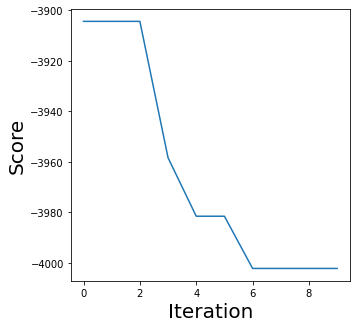

In [12]:
opt_ga = ev_opts.GA(Dimer, sequences, parameters, 
                    eval_fn=get_buff_total_energy,
                    build_fn=build_model)

opt_ga.run_opt(pop_size=200,
               generations=10,
               cores=1,
               plot=True)

In [13]:
best_dimer = opt_ga.best_model
best_idx = opt_ga.halloffame[0]
final_params = opt_ga.parse_individual(best_idx)
print(final_params)

[<Assembly (scapTet) containing 1 Polypeptide>, 23.225673752156293, 126.8078686210996, 237.6665472357119, 125.75902110334911, 170.87402408834987, 144.99809613861208]


In [13]:
final_params = [monomer, 23.225673752156293, 126.8078686210996, 237.6665472357119, 125.75902110334911, 170.87402408834987, 144.99809613861208]
best_dimer = Dimer(*final_params)

In [14]:
from protein_design.utils import visualise

# visualise the best dimer 
view = visualise(best_dimer)
view.clear()
view.add_ball_and_stick('protein', color_scheme='residueindex')
view

NGLWidget()

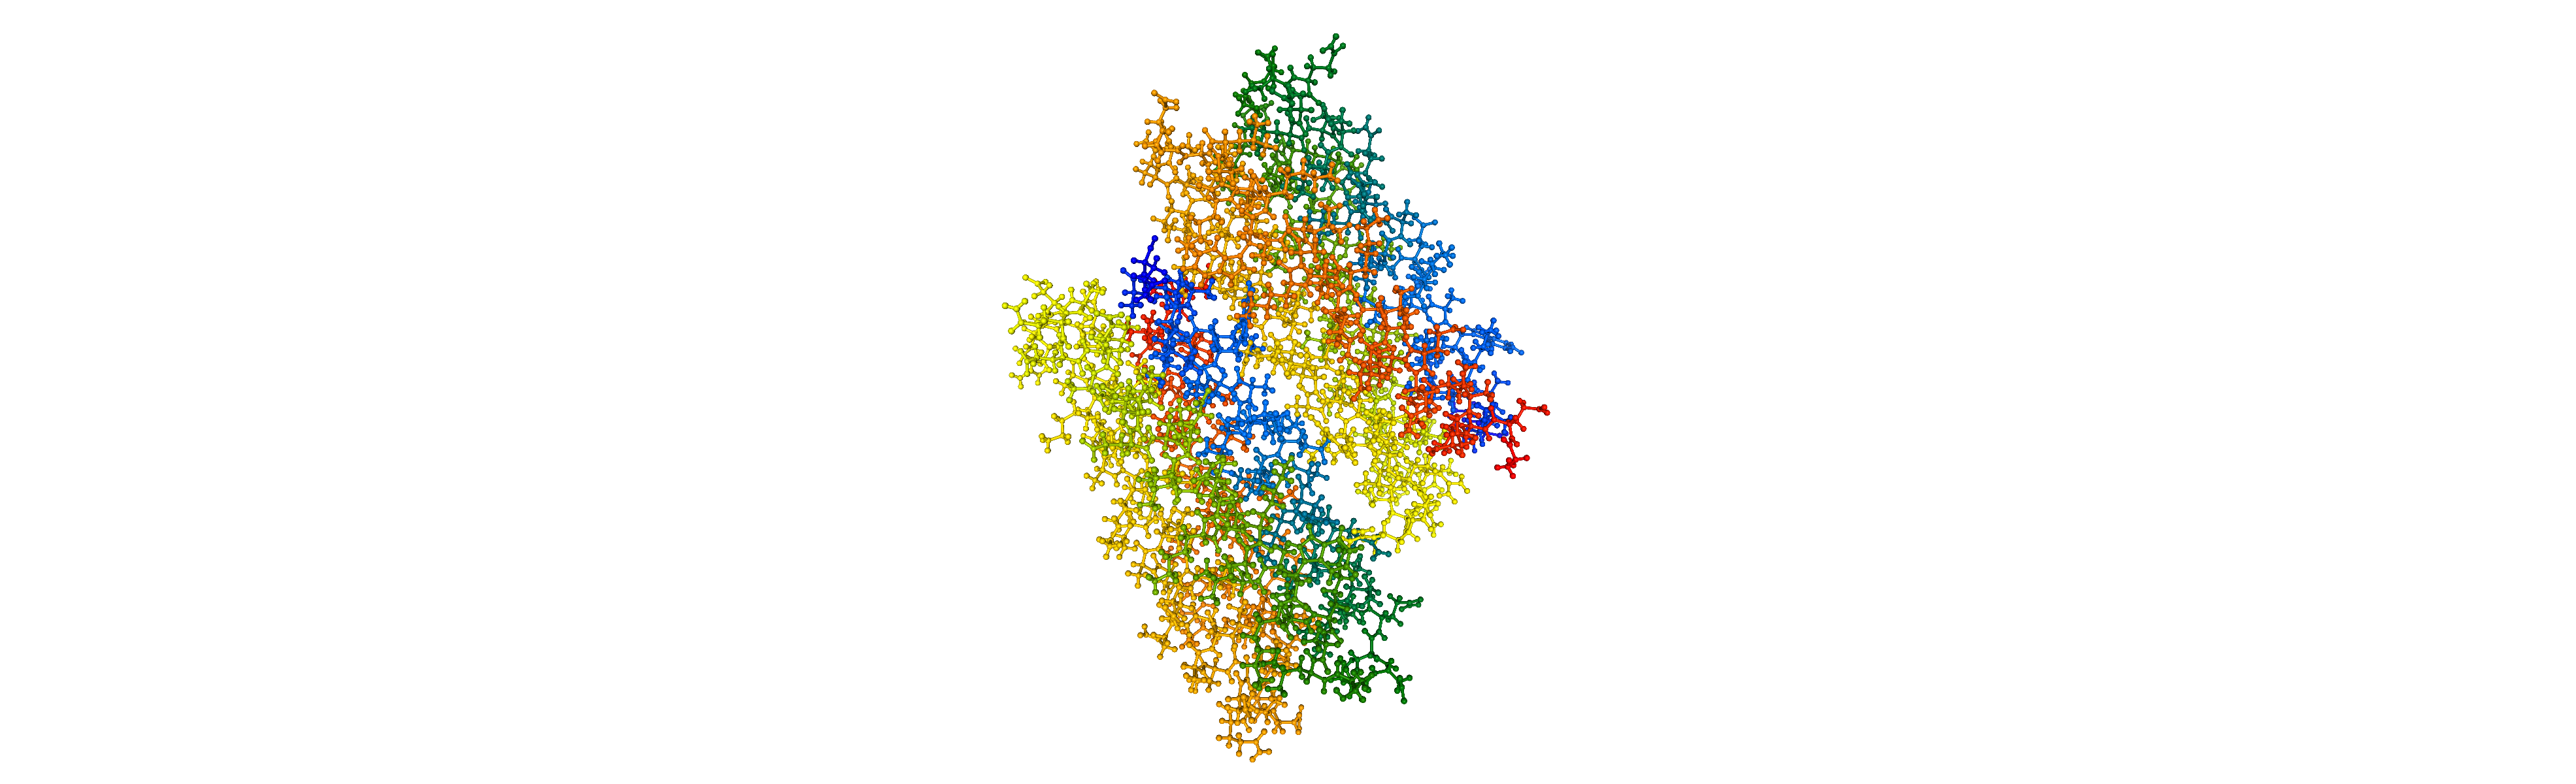

In [17]:
view.render_image()
view._display_image()

In [18]:
# Saving the best dimer PDB file
with open('best_dimer.pdb', 'w') as f:
    f.write(best_dimer.pdb)

# Lattice made of hetero-dimers

Here, we build a simple 'monoclinic' lattice from the hetero-dimer. Note, that this is not the only way to tile a plane. 

The resulting assembly has 12 parameters, and should represent a general monoclinic lattice (with a unit cell of a single dimer). 

Using a similar approach, one can build more complex tilings.

In [18]:
from protein_design.specifications import Lattice
lattice = Lattice(monomer, r=21, theta=90, phi=0, alpha=0, beta=180, gamma=0,
                lattice_a=42, lattice_b=22, lattice_theta=90,
                lattice_alpha=0, lattice_beta=0, lattice_gamma=0,
                next_nearest_nb=True)

In [19]:
view = lattice.visualise()
view.camera = 'orthographic'
view

NGLWidget()

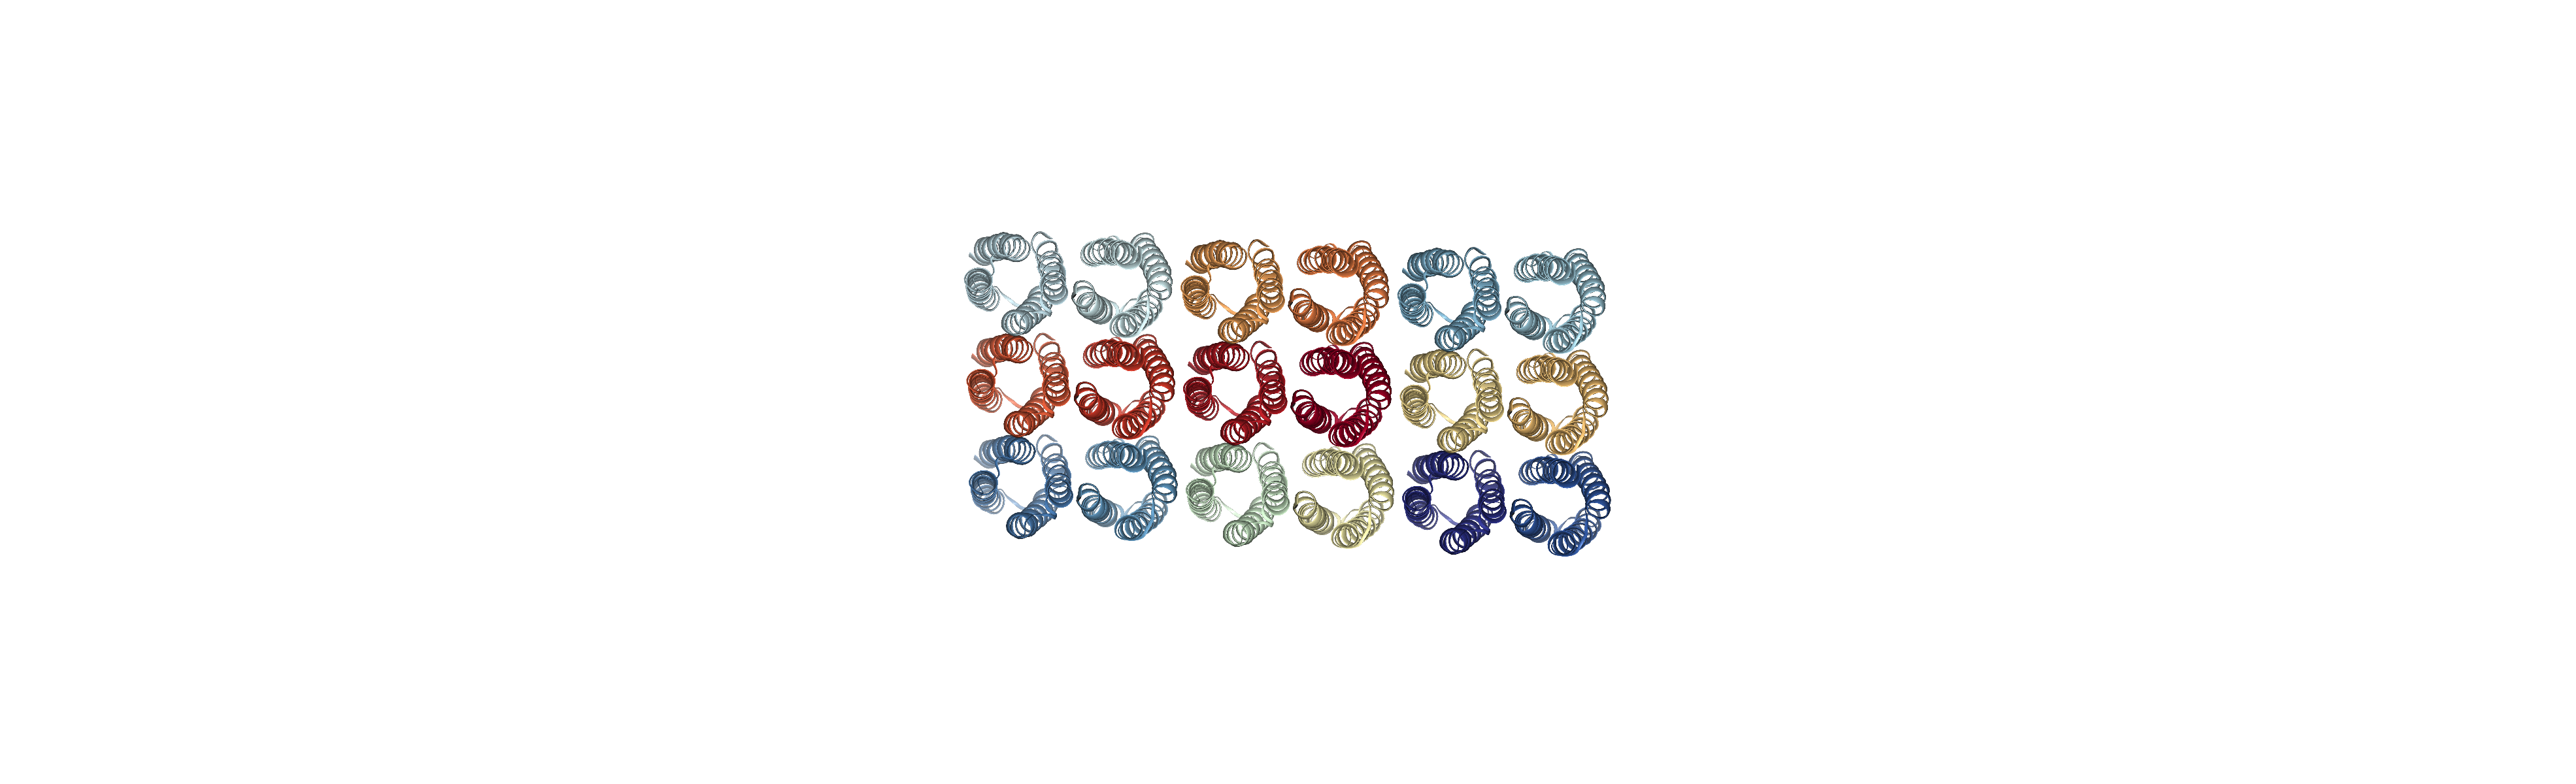

In [21]:
view.render_image()
view._display_image()

## Optimise the lattice
The parametric model has too many (12) parameters. Trying to optimise all of these parameters at once might be very inefficient.

To speed up things, in the following, we only consider the central dimer and its nearest neighbours (i.e. the assembly will have 5 dimers, or 10 monomers). 

Note, we can exploit the symmetries of the tiling when we build the model (i.e. using option '#' when packing side-chain using Scrwl4) and when we calculate the energy (e.g. BUDE energy) and only consider the asymmetric unit of the lattice. As far as I know, the budeff module is not symmetry-aware. Therefore, one needs to extend it first. Here, we will take a brute-force approach, instead. 

In [22]:
from isambard.optimisation.evo_optimizers import Parameter

parameters = [
    Parameter.static('monomer', monomer),
    Parameter.dynamic('a', 22, 3),
    Parameter.dynamic('theta', 90, 90),
    Parameter.dynamic('phi', 180, 180),
    Parameter.dynamic('alpha', 180, 180),
    Parameter.dynamic('beta', 90, 90),
    Parameter.dynamic('gamma', 180, 180),
    Parameter.dynamic('lattice_a', 30, 12),
    Parameter.dynamic('lattice_b', 30, 12),
    Parameter.dynamic('lattice_theta', 60, 30),
    Parameter.dynamic('lattice_alpha', 180, 180),
    Parameter.dynamic('lattice_beta',  90, 90),    
    Parameter.dynamic('lattice_gamma', 180, 180),
    Parameter.static('next_nearest_nb', False)
]

lattice = Lattice(*[p.default_value for p in parameters])

In [23]:
sequences = ["""
                G  ELEALAQ ELEALAQ KLKALAQ KLKAL   TSDS 
                Q  ELEELAE ALEDLAE WLKELAQ KLKA    RARLD
                AQ ELEELAE ELEELAE WLKDLAQ KLKAL   TSDS
                Q  ELEALAQ ELEALAE KLKALAQ KLKALAQ
             """,
             """
                G  ELERLAA ELERLAK KLKALAQ KLKAL   TSDS
                Q  ELEALAQ ELEALAE KLKALAQ KLKA    RARLD
                AQ ELEALAQ ELEALAQ KLKALAQ KLKAL   TSDS
                Q  ELERLAR ELEKLAK KLKALAQ KLKALAQ
             """]

all_sequences = []
for i in range(len(lattice)//2):
    all_sequences.extend([s.replace(" ", "").replace("\n", "") for s in sequences])
all_sequences

['GELEALAQELEALAQKLKALAQKLKALTSDSQELEELAEALEDLAEWLKELAQKLKARARLDAQELEELAEELEELAEWLKDLAQKLKALTSDSQELEALAQELEALAEKLKALAQKLKALAQ',
 'GELERLAAELERLAKKLKALAQKLKALTSDSQELEALAQELEALAEKLKALAQKLKARARLDAQELEALAQELEALAQKLKALAQKLKALTSDSQELERLARELEKLAKKLKALAQKLKALAQ',
 'GELEALAQELEALAQKLKALAQKLKALTSDSQELEELAEALEDLAEWLKELAQKLKARARLDAQELEELAEELEELAEWLKDLAQKLKALTSDSQELEALAQELEALAEKLKALAQKLKALAQ',
 'GELERLAAELERLAKKLKALAQKLKALTSDSQELEALAQELEALAEKLKALAQKLKARARLDAQELEALAQELEALAQKLKALAQKLKALTSDSQELERLARELEKLAKKLKALAQKLKALAQ',
 'GELEALAQELEALAQKLKALAQKLKALTSDSQELEELAEALEDLAEWLKELAQKLKARARLDAQELEELAEELEELAEWLKDLAQKLKALTSDSQELEALAQELEALAEKLKALAQKLKALAQ',
 'GELERLAAELERLAKKLKALAQKLKALTSDSQELEALAQELEALAEKLKALAQKLKARARLDAQELEALAQELEALAQKLKALAQKLKALTSDSQELERLARELEKLAKKLKALAQKLKALAQ',
 'GELEALAQELEALAQKLKALAQKLKALTSDSQELEELAEALEDLAEWLKELAQKLKARARLDAQELEELAEELEELAEWLKDLAQKLKALTSDSQELEALAQELEALAEKLKALAQKLKALAQ',
 'GELERLAAELERLAKKLKALAQKLKALTSDSQELEALAQELEALAEKLKALAQKLKARARLDAQELEALAQELEALAQKLKALAQKLKALTSDSQELERLAR

*This is an extremely short optimisation, only meant for demonstration.*

gen	evals	avg     	std    	min     	max
0  	10   	-143.296	624.612	-2865.92	0  
1  	11   	-143.296	624.612	-2865.92	0  
2  	12   	-143.296	624.612	-2865.92	0  
3  	12   	-776.701	2798.47	-12668.1	0  
4  	18   	-776.701	2798.47	-12668.1	0  
Evaluated 83 models in total in 0:06:09.093756
Best fitness is (-12668.099669770076,)
Best parameters are [<Assembly (scapTet) containing 1 Polypeptide>, 21.77366453501897, 67.16714583805148, 200.2241927253556, 153.33223618236028, 154.58622791807673, 36.29020663388147, 40.57376294510989, 30.142416169283898, 47.59768824358062, 288.4497785858005, 100.05797289757622, 120.8758096351252, False]
----Minimisation plot:


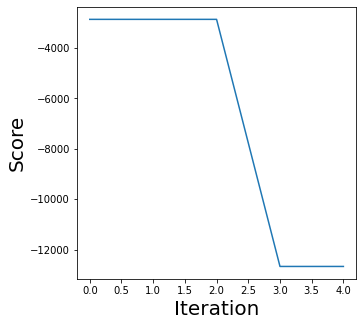

In [24]:
from protein_design.specifications import get_buff_total_energy
from protein_design.specifications import build_model
import isambard.optimisation.evo_optimizers as ev_opts

opt_ga = ev_opts.GA(Lattice, all_sequences, parameters, 
                    eval_fn=get_buff_total_energy,
                    build_fn=build_model)

opt_ga.run_opt(pop_size=20,
               generations=5,
               cores=1,
               plot=True)

In [25]:
best_dimer = opt_ga.best_model
best_idx = opt_ga.halloffame[0]
final_params = opt_ga.parse_individual(best_idx)
print(final_params)

[<Assembly (scapTet) containing 1 Polypeptide>, 21.77366453501897, 67.16714583805148, 200.2241927253556, 153.33223618236028, 154.58622791807673, 36.29020663388147, 40.57376294510989, 30.142416169283898, 47.59768824358062, 288.4497785858005, 100.05797289757622, 120.8758096351252, False]


In [26]:
# visualise the best dimer 
view = visualise(best_dimer)
view

NGLWidget()